In [1]:
#We can go into our root file and see what Trees are availiable
%matplotlib inline
import sys, os
if __package__ is None:
    import sys, os
    sys.path.append(os.path.realpath("/data/shared/Software/"))
    sys.path.append(os.path.realpath("../../"))
import matplotlib.pyplot as plt
from matplotlib import mlab
import numpy as np
import pandas as pd
import ntpath
import glob
import deepconfig
from keras.datasets import mnist
from keras import objectives
from keras import backend as K

from keras.utils.visualize_util import plot
from keras.utils import np_utils
from IPython.display import Image, display

from CMS_SURF_2016.utils.metrics import plot_history, print_accuracy_m
from CMS_SURF_2016.utils.callbacks import OverfitStopping, SmartCheckpoint
from CMS_SURF_2016.utils.keras_trial import *

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Reshape, Activation, Dropout, Convolution2D, merge, Input, Lambda
from keras.callbacks import EarlyStopping


dc = deepconfig.deepconfig(gpu='gpu0', backend='theano')

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN not available)

Couldn't import dot_parser, loading of dot files will not be possible.
using gpu0
using theano


In [55]:
def genModel(latent_dim):
    
    input_img = Input(shape=(784,))

    # "encoded" is the encoded representation of the input
    encoded = Dense(128, activation='relu')(input_img)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(latent_dim, activation='relu')(encoded)

    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(784, activation='sigmoid')(decoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input=input_img, output=decoded)

    # this model maps an input to its encoded representation
    encoder = Model(input=input_img, output=encoded)

    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(latent_dim,))

    #encoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

    # retrieve the last layer of the autoencoder model
    decoder_layer1 = autoencoder.layers[-3]
    decoder_layer2 = autoencoder.layers[-2]
    decoder_layer3 = autoencoder.layers[-1]

    # create the decoder model
    decoder = Model(input=encoded_input, output=decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))

    # Now let's train our autoencoder to reconstruct MNIST digits.
    # First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['accuracy'])
    #autoencoder.compile(optimizer='sgd', loss='mse',metrics=['accuracy'])
    
    return encoder,autoencoder, decoder

Removing '9' from dateaset

In [24]:
outlier = 7

(x_train,y_train), (x_test,y_test) = mnist.load_data()

x_train = x_train[y_train!=outlier]
y_train = y_train[y_train!=outlier]

x_test_outlier = x_test[y_test==outlier]
x_test = x_test[y_test!=outlier]
y_test_outlier = y_test[y_test==outlier]
y_test = y_test[y_test!=outlier]

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [4]:
results = {}

In [29]:
batch_size = 100
nb_epoch = 50000000
latent_dim = [2,4,8,16,32]
for dim in latent_dim:
    earlyStopping = EarlyStopping(verbose=1, patience=1)
    overfitStopping = OverfitStopping(verbose=1, patience=20)
    cod,ae,dec = genModel(dim)
    fitTime = time.time()
    hist = ae.fit(x_train, x_train,
            shuffle=True,
            nb_epoch=nb_epoch,
            batch_size=batch_size,
            callbacks=[earlyStopping],#, overfitStopping],
            validation_data=(x_test, x_test))
    fitTime = time.time() - fitTime
    results[dim] = {'Time':fitTime,
                   'hist':hist,
                   'Autoencoder':ae,
                   'Coder':cod,
                   'Decoder':dec}
    

Train on 53735 samples, validate on 8972 samples
Epoch 1/50000000
53735/53735 [==============================] - 2s - loss: 0.3680 - acc: 0.0131 - val_loss: 0.2604 - val_acc: 0.0167
Epoch 2/50000000
53735/53735 [==============================] - 2s - loss: 0.2547 - acc: 0.0160 - val_loss: 0.2517 - val_acc: 0.0157
Epoch 3/50000000
53735/53735 [==============================] - 2s - loss: 0.2502 - acc: 0.0156 - val_loss: 0.2497 - val_acc: 0.0160
Epoch 4/50000000
53735/53735 [==============================] - 2s - loss: 0.2479 - acc: 0.0146 - val_loss: 0.2476 - val_acc: 0.0147
Epoch 5/50000000
53735/53735 [==============================] - 2s - loss: 0.2451 - acc: 0.0137 - val_loss: 0.2446 - val_acc: 0.0146
Epoch 6/50000000
53735/53735 [==============================] - 2s - loss: 0.2429 - acc: 0.0140 - val_loss: 0.2427 - val_acc: 0.0139
Epoch 7/50000000
53735/53735 [==============================] - 2s - loss: 0.2414 - acc: 0.0150 - val_loss: 0.2412 - val_acc: 0.0163
Epoch 8/50000000
537

In [30]:
for dim,info in results.iteritems():
    print "bottleneck",dim
    info['Loss'],info['Acc'] = info['Autoencoder'].evaluate(x_test, x_test, batch_size=batch_size)
    prediction = info['Autoencoder'].predict(x_test)
    
    info['Loss_outlier'],info['Acc_outlier'] = info['Autoencoder'].evaluate(x_test_outlier,x_test_outlier, batch_size=batch_size)
    prediction_outlier = info['Autoencoder'].predict(x_test_outlier)
    
    info['MSE'] = np.sqrt(np.mean( (prediction-x_test)**2,axis=1)) 
    info['MSE_outlier'] = np.sqrt(np.mean( (prediction_outlier-x_test_outlier)**2,axis=1))
    
    info['NumberParam'] = info['Autoencoder'].count_params()
    print 'Fitting time: ',info['Time']

bottleneck 16
1028/1028 [==============================] - 0s     
Fitting time:  114.292114019
bottleneck 8
1028/1028 [==============================] - 0s     
Fitting time:  103.31851387
bottleneck 2
1028/1028 [==============================] - 0s     
Fitting time:  148.842765093
bottleneck 4
1028/1028 [==============================] - 0s     
Fitting time:  94.9191391468
bottleneck 32
1028/1028 [==============================] - 0s     
Fitting time:  88.5461480618


In [9]:
def show_one(model, number):
    plt.imshow(number.reshape(28,28))
    plt.show()
    image = model.predict( number.reshape(1,784) )
    plt.imshow(image[0].reshape(28,28))
    plt.show()
    print np.sqrt(np.mean( (image[0]-number)**2))

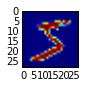

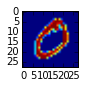

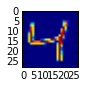

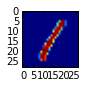

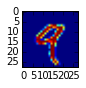

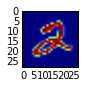

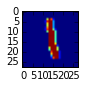

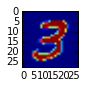

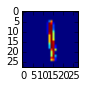

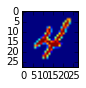

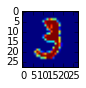

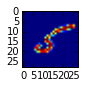

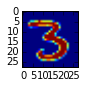

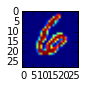

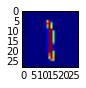

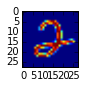

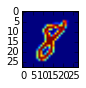

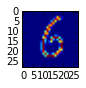

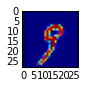

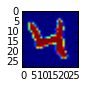

In [10]:
for img in x_train[:20]:
    plt.figure(figsize=(1, 1))
    plt.imshow(img.reshape(28,28))
    plt.show()

Dimension 16 


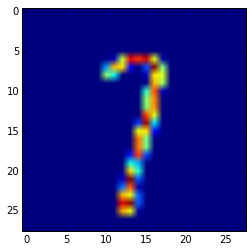

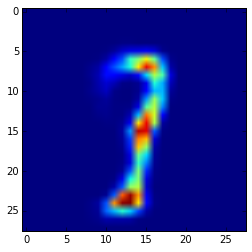

0.0958028215922
 
Dimension 8 


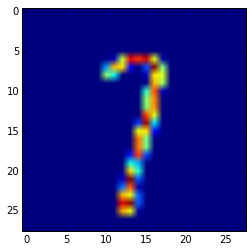

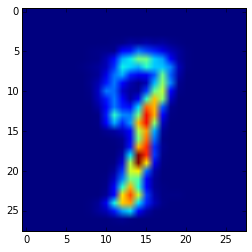

0.102963575149
 
Dimension 2 


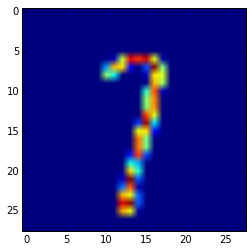

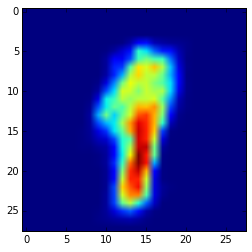

0.16756532706
 
Dimension 4 


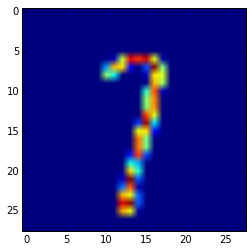

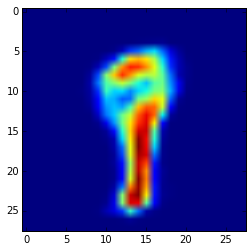

0.154713442588
 
Dimension 32 


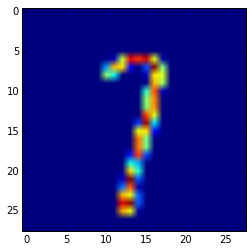

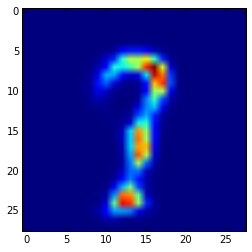

0.102577671767
 


In [32]:
for dim in results:
    print 'Dimension %d '% dim
    show_one( results[dim]['Autoencoder'], x_test_outlier[23])
    print' '

Dimension 16 


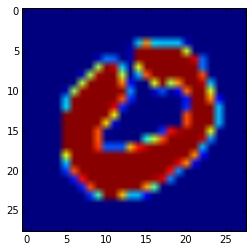

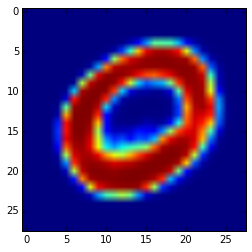

0.143955316434
 
Dimension 8 


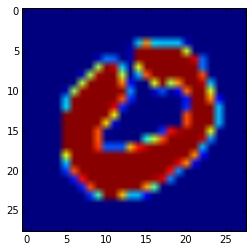

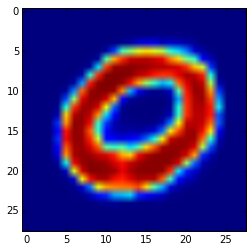

0.163134617382
 
Dimension 2 


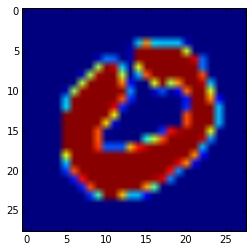

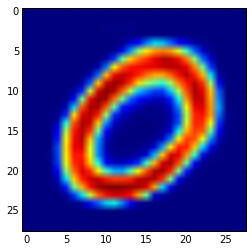

0.235659032018
 
Dimension 4 


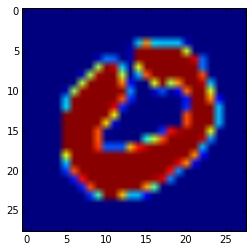

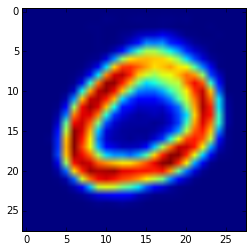

0.224670820676
 
Dimension 32 


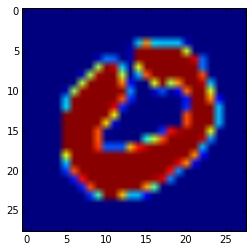

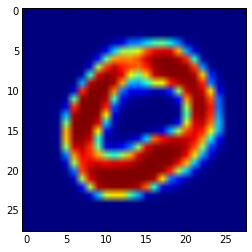

0.140949048681
 


In [36]:
for dim in results:
    print 'Dimension %d '% dim
    show_one( results[dim]['Autoencoder'], x_test[23])
    print ' '

In [37]:
def show(info):
    for key in ['Time','Acc','Acc_outlier','Loss','Loss_outlier','MSE','MSE_outlier','NumberParam']:
        print key, info.get(key,'n/a')

In [39]:
for dim in results:
    print 'Dimension %d '% dim
    show(results[dim])
    print ' '

Dimension 16 
Time 114.292114019
Acc 0.0135978597257
Acc_outlier 0.0116731514901
Loss 0.115158269505
Loss_outlier 0.128563161577
MSE [ 0.16316646  0.05351514  0.10935648 ...,  0.10343379  0.16067535
  0.13662572]
MSE_outlier [ 0.15571136  0.15872675  0.15347656 ...,  0.15472911  0.11911119
  0.13653882]
NumberParam 220320
 
Dimension 8 
Time 103.31851387
Acc 0.0120374495749
Acc_outlier 0.0107003889963
Loss 0.137479621072
Loss_outlier 0.172174551434
MSE [ 0.19703647  0.05389403  0.15403218 ...,  0.12394093  0.20953563
  0.17630152]
MSE_outlier [ 0.19558947  0.26137001  0.18283932 ...,  0.17670107  0.1827652
  0.16018848]
NumberParam 219288
 
Dimension 2 
Time 148.842765093
Acc 0.0106999552018
Acc_outlier 0.0116731515553
Loss 0.1951879166
Loss_outlier 0.221170838995
MSE [ 0.26007935  0.08600817  0.20713468 ...,  0.1794226   0.21934695
  0.23834959]
MSE_outlier [ 0.24535321  0.26994488  0.21458096 ...,  0.23053692  0.22285989
  0.2419318 ]
NumberParam 218514
 
Dimension 4 
Time 94.9191391

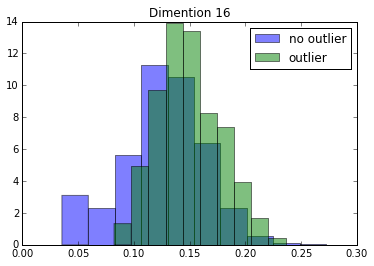

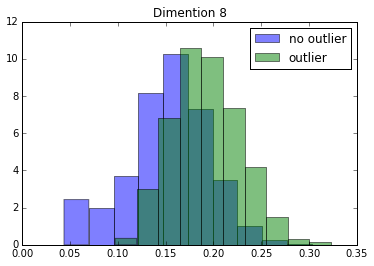

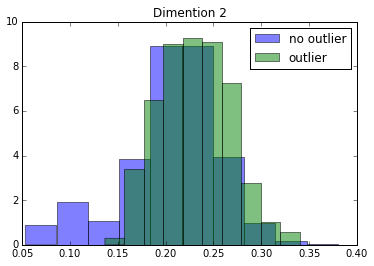

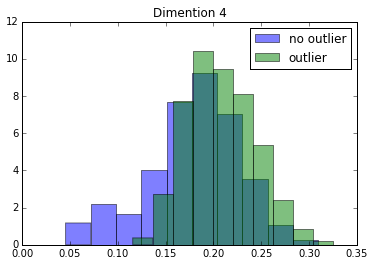

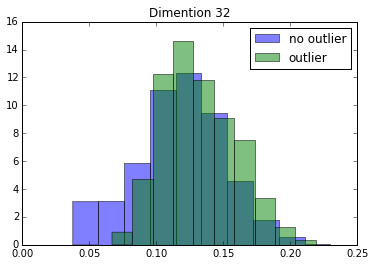

In [40]:
for dim in results:
    plt.title('Dimention %d' % dim)
    plt.hist( results[dim]['MSE'], alpha=0.5, label='no outlier', normed=1)
    plt.hist( results[dim]['MSE_outlier'], alpha=0.5, label='outlier',normed=1)
    plt.legend()
    plt.show()

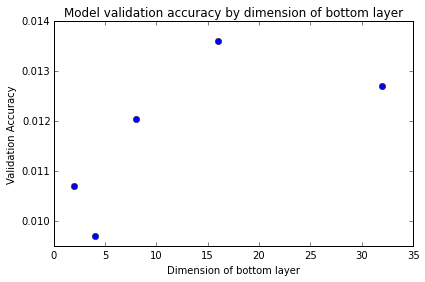

In [53]:
# Get the plot of validation accuracy by dimension of bottom layer
plt.xlabel('Dimension of bottom layer')
plt.ylabel('Validation Accuracy')
plt.title('Model validation accuracy by dimension of bottom layer')

x = results.keys()
y = [results[d]['Acc'] for d in x] 
plt.plot (x, y, 'bo')
plt.tight_layout()
plt.show()

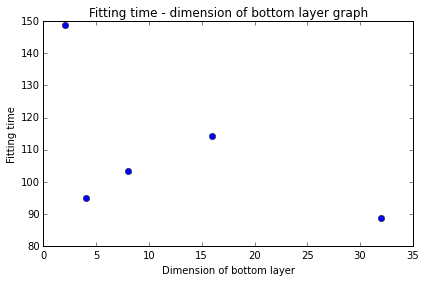

Help on function plot in module matplotlib.pyplot:

plot(*args, **kwargs)
    Plot lines and/or markers to the
    :class:`~matplotlib.axes.Axes`.  *args* is a variable length
    argument, allowing for multiple *x*, *y* pairs with an
    optional format string.  For example, each of the following is
    legal::
    
        plot(x, y)        # plot x and y using default line style and color
        plot(x, y, 'bo')  # plot x and y using blue circle markers
        plot(y)           # plot y using x as index array 0..N-1
        plot(y, 'r+')     # ditto, but with red plusses
    
    If *x* and/or *y* is 2-dimensional, then the corresponding columns
    will be plotted.
    
    An arbitrary number of *x*, *y*, *fmt* groups can be
    specified, as in::
    
        a.plot(x1, y1, 'g^', x2, y2, 'g-')
    
    Return value is a list of lines that were added.
    
    By default, each line is assigned a different color specified by a
    'color cycle'.  To change this behavior, you can 

In [52]:
# Get the plot of model fitting time by dimension of bottom layer
plt.xlabel('Dimension of bottom layer')
plt.ylabel('Fitting time')
plt.title('Fitting time - dimension of bottom layer graph')

x = results.keys()
y = [results[d]['Time'] for d in x] 
plt.plot (x, y, 'bo')
plt.tight_layout()
plt.show()
help(plt.plot)

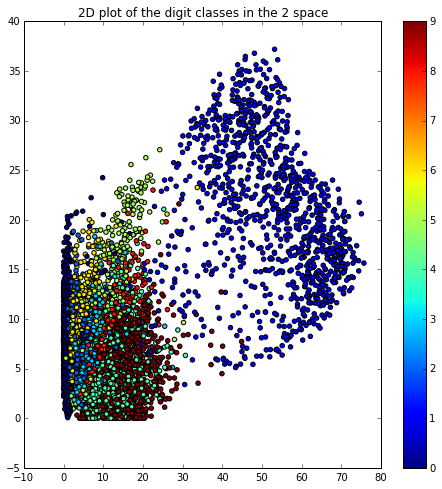

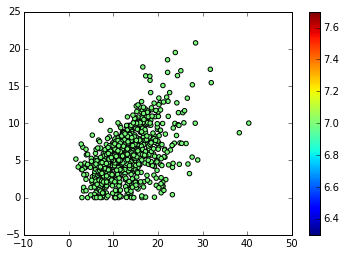

In [54]:
x_test_encoded= results[2]['Coder'].predict(x_test, batch_size=batch_size)
x_test_outlier_encoded= results[2]['Coder'].predict(x_test_outlier, batch_size=batch_size)

plt.figure(figsize=(8, 8))
plt.title('2D plot of the digit classes in the %r space' % 2)
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()
plt.scatter(x_test_outlier_encoded[:, 0], x_test_outlier_encoded[:, 1], c=y_test_outlier)
plt.colorbar()
plt.show()

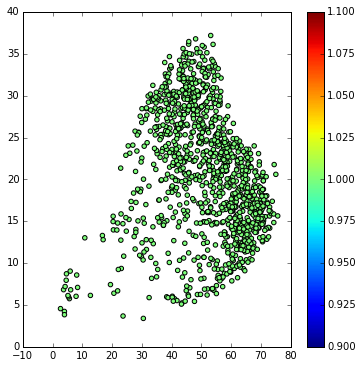

In [46]:
number= 1
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[y_test==number][:, 0], x_test_encoded[y_test==number][:, 1], c=y_test[y_test==number])
plt.colorbar()
plt.show()

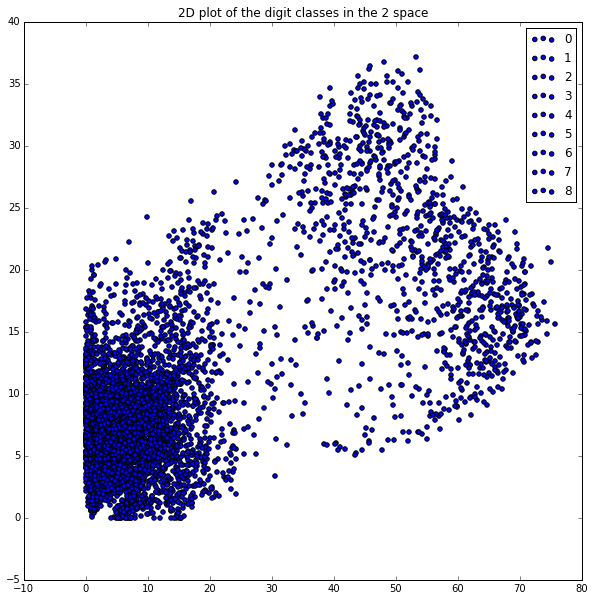

In [47]:
plt.figure(figsize=(10, 10))
plt.title('2D plot of the digit classes in the %r space' % 2)
for i in range(9):
    subdata = x_test_encoded[y_test==i]
    sublabel = np.array(y_test[y_test==i])
    plt.scatter(subdata[:, 0], subdata[:, 1],label='%d'%i)
#plt.colorbar()
plt.legend()
plt.show()